In [1]:
!pip install matplotlib
!pip install seaborn
!pip install squarify


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


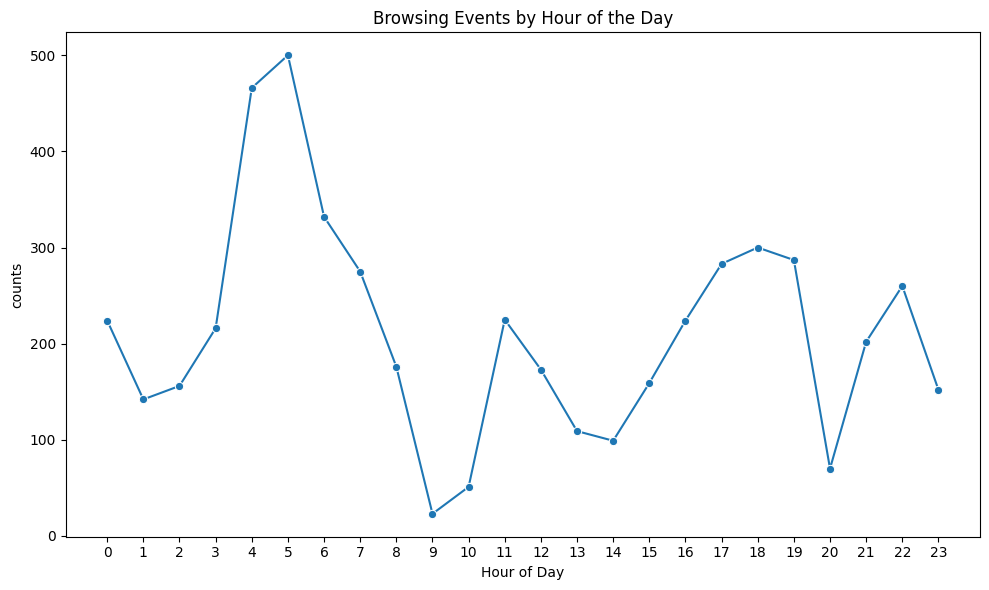

C:\Users\User\AppData\Local\Temp\ipykernel_26576\288869939.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=transition_counts.index, x=transition_counts.values, palette='mako')


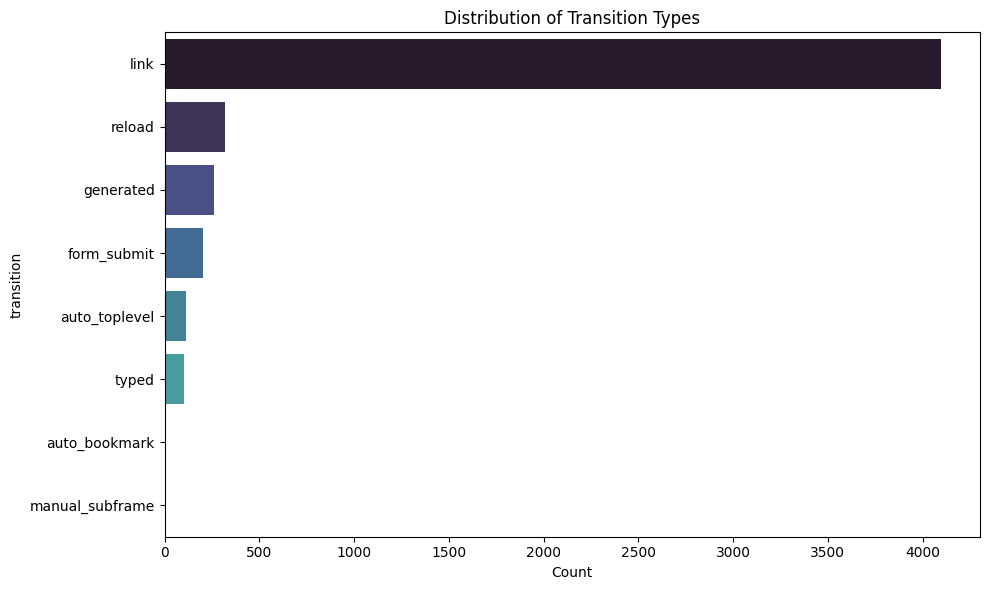

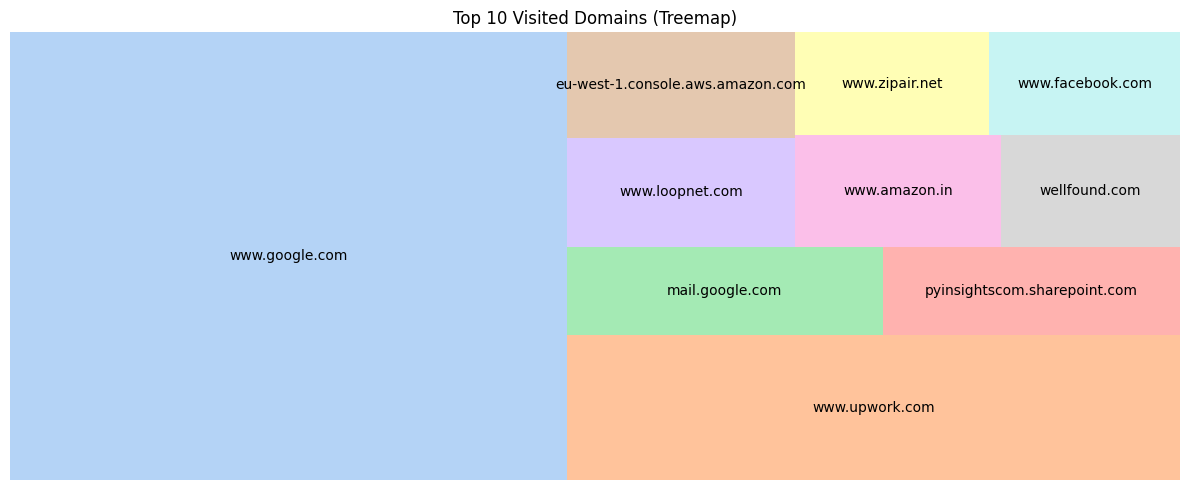

Null titles: 53 (1.0%)


C:\Users\User\AppData\Local\Temp\ipykernel_26576\288869939.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_counts.index, x=title_counts.values, palette='Spectral')


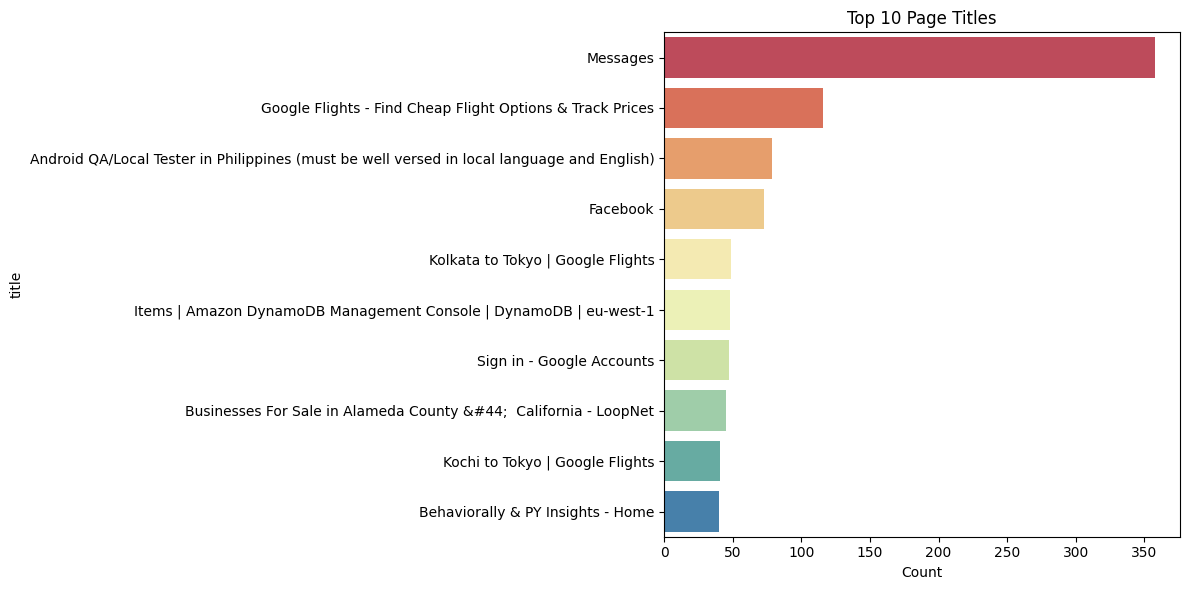

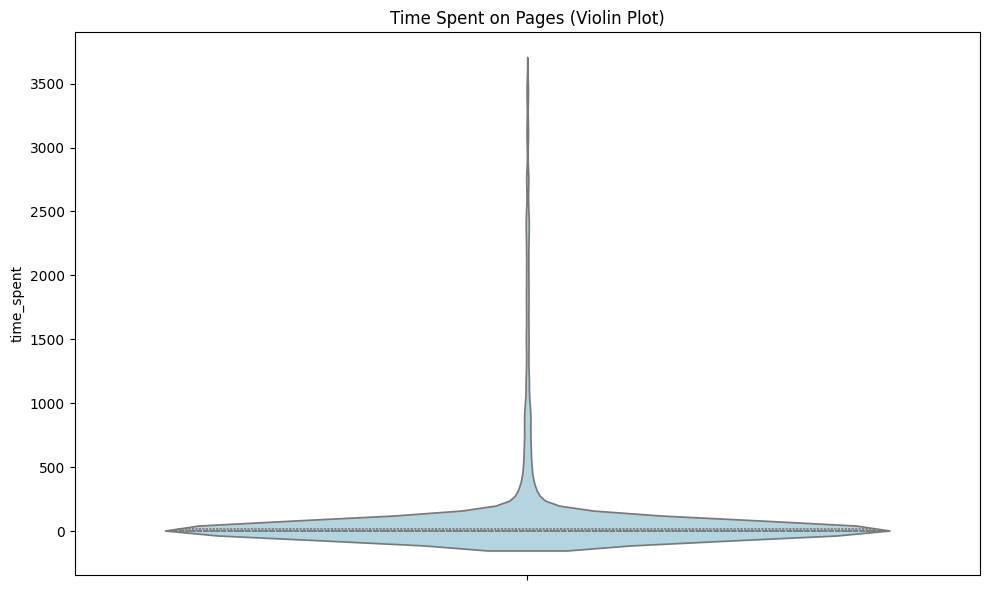

C:\Users\User\AppData\Local\Temp\ipykernel_26576\288869939.py:105: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(reasonable_time['time_spent'], shade=True, color='coral')


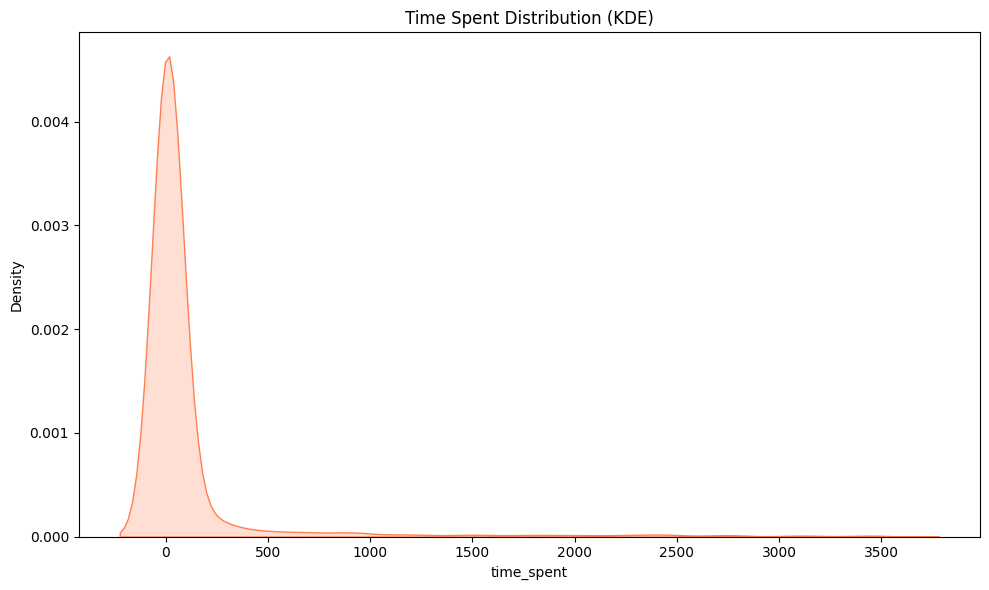

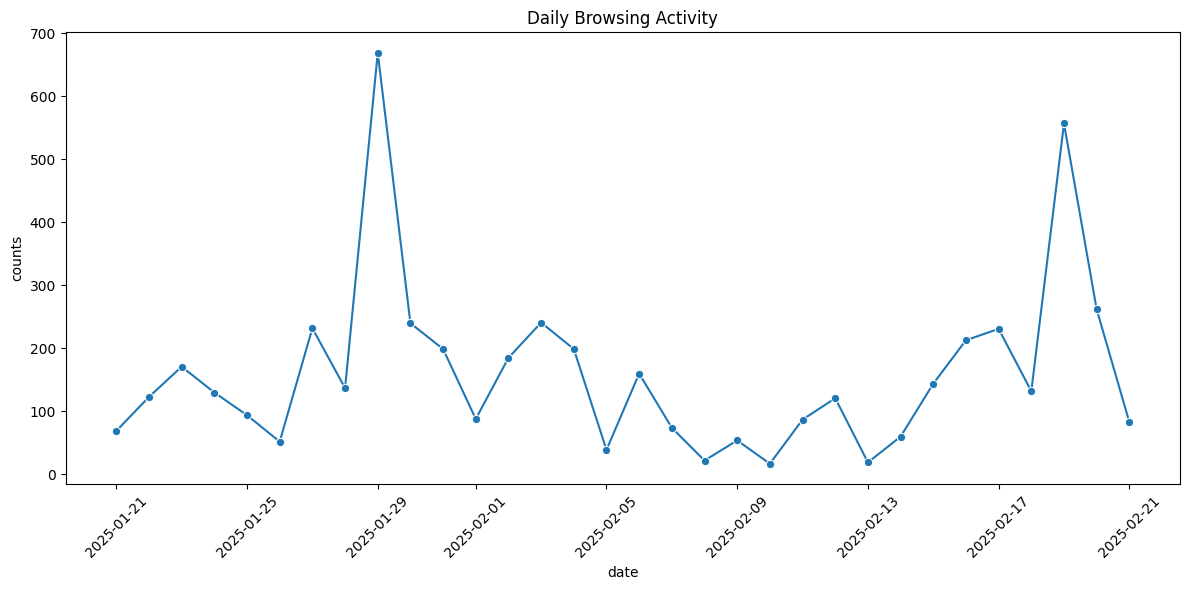


Session Analysis:
Total sessions: 267
Avg duration: 17.63 mins
Median duration: 3.41 mins


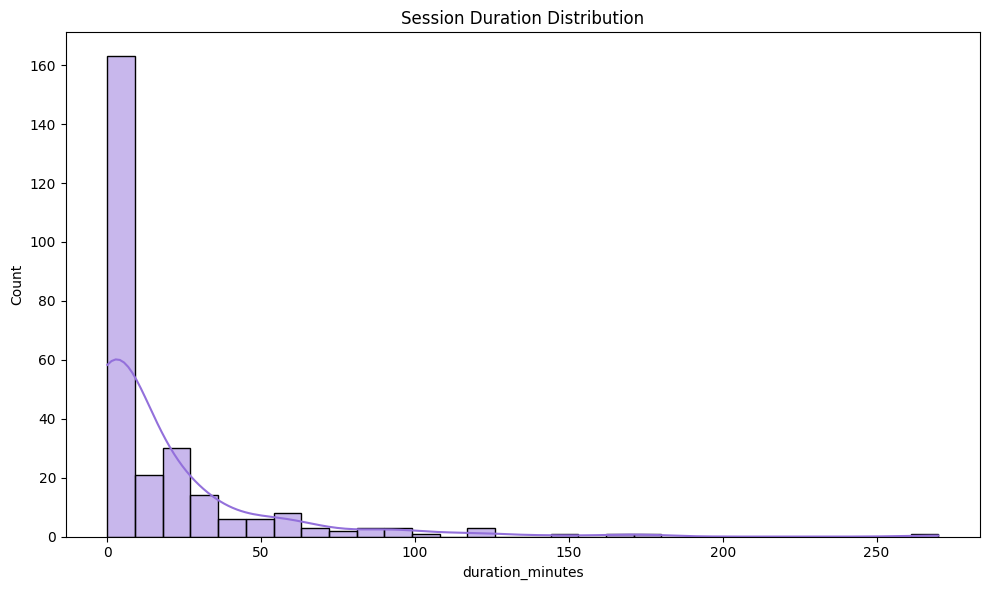

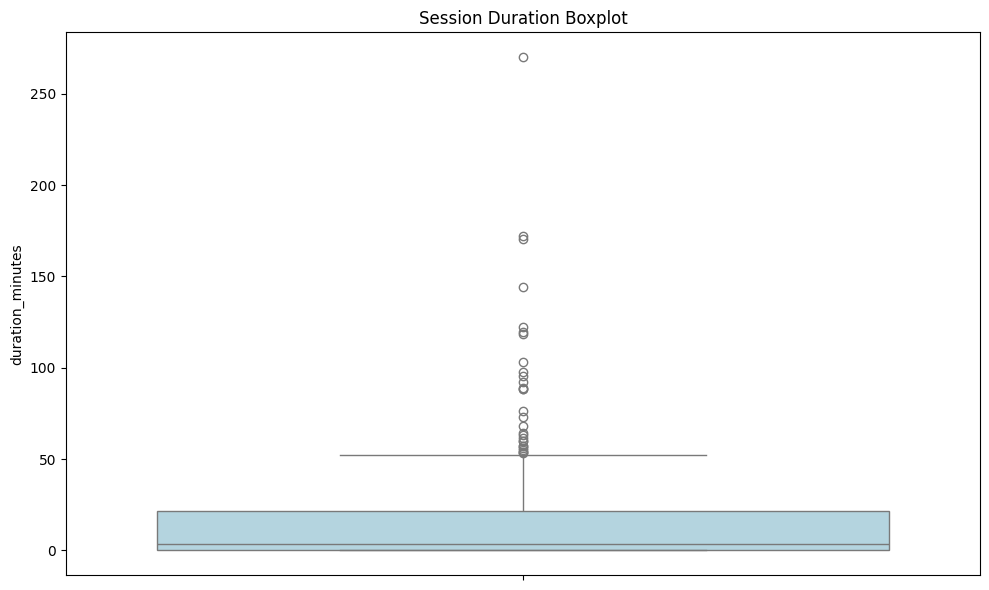

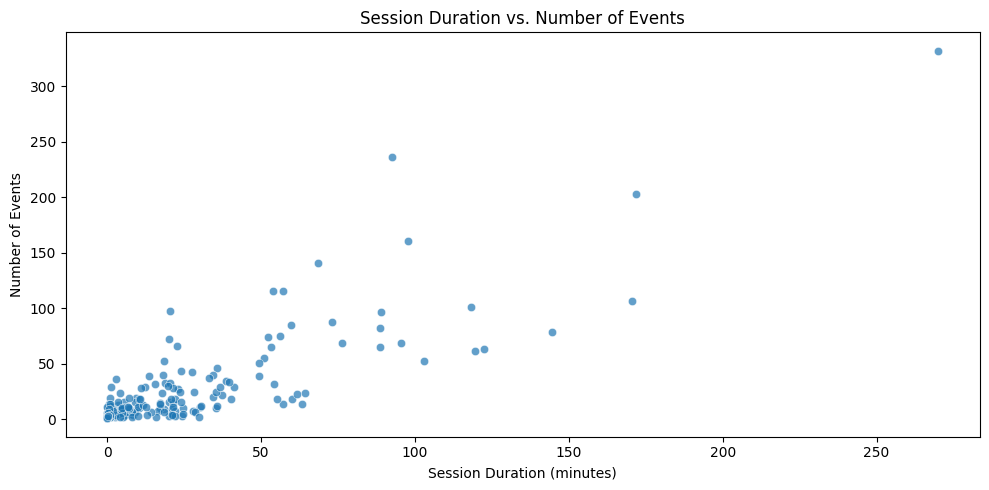

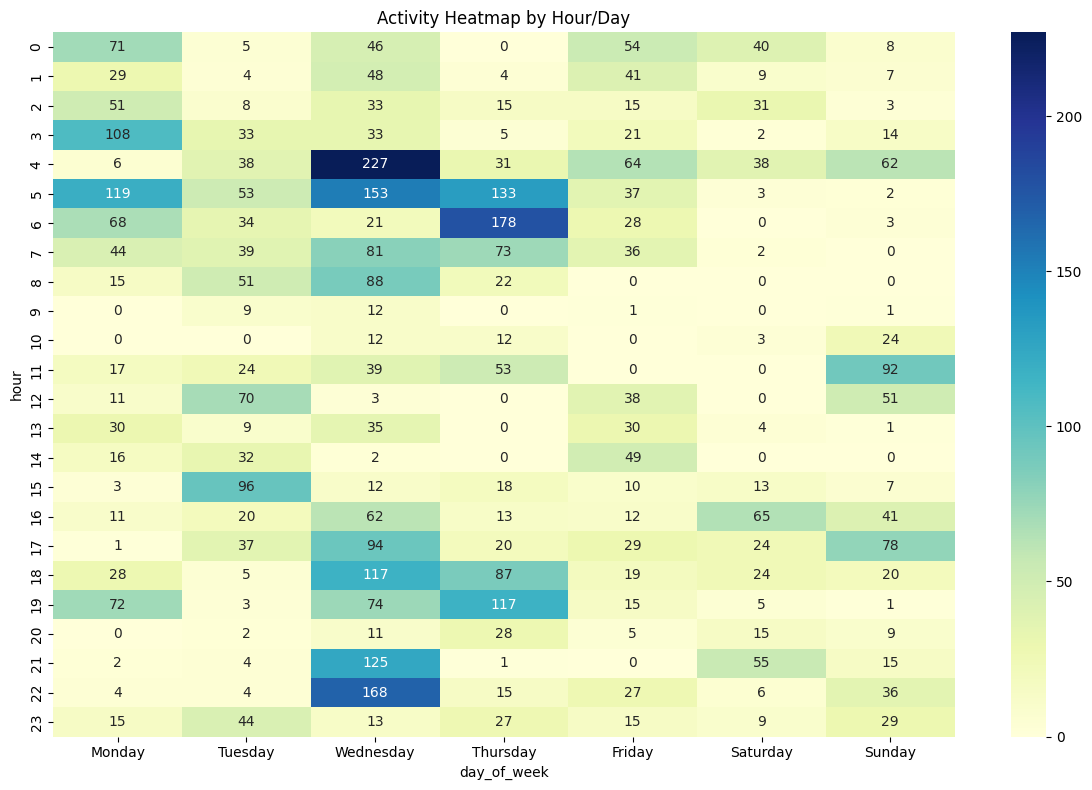

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import numpy as np
from urllib.parse import urlparse
from collections import defaultdict

# --------------------------
# Data Loading & Cleaning
# --------------------------

def load_and_clean_data(file_path):
    """Load and clean raw browsing data CSV file."""
    df = pd.read_csv(file_path, encoding='utf-8', header=None)
    df = df.iloc[5:].reset_index(drop=True)
    headers = df.iloc[0].tolist()
    df_browsing = df.iloc[1:].reset_index(drop=True)
    df_browsing.columns = headers
    
    # Convert datetime
    df_browsing['eventtimeutc'] = pd.to_datetime(df_browsing['eventtimeutc'], errors='coerce')
    df_browsing['eventtime'] = pd.to_datetime(df_browsing['eventtime'], errors='coerce')
    df_browsing = df_browsing.dropna(subset=['eventtimeutc'])
    return df_browsing.reset_index(drop=True)

# --------------------------
# Feature Engineering
# --------------------------

def extract_domain(url):
    """Extract domain from URL."""
    try:
        parsed = urlparse(url)
        return parsed.netloc if parsed.netloc else url
    except:
        return 'unknown'

def add_features(df):
    """Add all engineered features."""
    df['domain'] = df['url'].apply(extract_domain)
    df['hour'] = df['eventtimeutc'].dt.hour
    df['day_of_week'] = df['eventtimeutc'].dt.day_name()
    df['date'] = df['eventtimeutc'].dt.date
    return df

# --------------------------
# Visualization Functions (All Original Analyses)
# --------------------------

def plot_hourly_trend(df):
    hourly_counts = df.groupby('hour').size().reset_index(name='counts')
    plt.figure(figsize=(10,6))
    sns.lineplot(x='hour', y='counts', data=hourly_counts, marker='o', sort=False)
    plt.title('Browsing Events by Hour of the Day')
    plt.xlabel('Hour of Day')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

def plot_transition_types(df):
    transition_counts = df['transition'].value_counts()
    plt.figure(figsize=(10,6))
    sns.barplot(y=transition_counts.index, x=transition_counts.values, palette='mako')
    plt.title('Distribution of Transition Types')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

def plot_top_domains(df):
    top_domains = df['domain'].value_counts().head(10)
    plt.figure(figsize=(12,5))
    squarify.plot(sizes=top_domains.values, label=top_domains.index, alpha=.8, color=sns.color_palette('pastel'))
    plt.axis('off')
    plt.title('Top 10 Visited Domains (Treemap)')
    plt.tight_layout()
    plt.show()

def plot_title_analysis(df):
    null_titles = df['title'].isna().sum()
    print(f"Null titles: {null_titles} ({null_titles/len(df)*100:.1f}%)")
    
    if len(df) - null_titles > 10:
        title_counts = df['title'].value_counts().head(10)
        plt.figure(figsize=(12,6))
        sns.barplot(y=title_counts.index, x=title_counts.values, palette='Spectral')
        plt.title('Top 10 Page Titles')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.show()

def plot_time_spent(df):
    df = df.sort_values('eventtimeutc').reset_index(drop=True)
    df['next_time'] = df['eventtimeutc'].shift(-1)
    df['time_spent'] = (df['next_time'] - df['eventtimeutc']).dt.total_seconds()
    reasonable_time = df[(df['time_spent'] > 0) & (df['time_spent'] < 3600)]
    
    plt.figure(figsize=(10,6))
    sns.violinplot(data=reasonable_time['time_spent'], inner='quartile', color='lightblue')
    plt.title('Time Spent on Pages (Violin Plot)')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10,6))
    sns.kdeplot(reasonable_time['time_spent'], shade=True, color='coral')
    plt.title('Time Spent Distribution (KDE)')
    plt.tight_layout()
    plt.show()

def plot_daily_trends(df):
    daily_counts = df.groupby('date').size().reset_index(name='counts')
    plt.figure(figsize=(12,6))
    sns.lineplot(x='date', y='counts', data=daily_counts, marker='o')
    plt.title('Daily Browsing Activity')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_sessions(df, gap_minutes=30):
    df = df.sort_values('eventtimeutc').reset_index(drop=True)
    df['session_gap'] = df['eventtimeutc'].diff().dt.total_seconds() / 60
    df['new_session'] = (df['session_gap'] > gap_minutes) | df['session_gap'].isna()
    df['session_id'] = df['new_session'].cumsum()
    
    # Session duration
    session_duration = df.groupby('session_id')['eventtimeutc'].agg(['min','max'])
    session_duration['duration_minutes'] = (session_duration['max'] - session_duration['min']).dt.total_seconds() / 60
    
    # Session statistics
    print("\nSession Analysis:")
    print(f"Total sessions: {len(session_duration)}")
    print(f"Avg duration: {session_duration['duration_minutes'].mean():.2f} mins")
    print(f"Median duration: {session_duration['duration_minutes'].median():.2f} mins")
    
    # Visualizations
    plt.figure(figsize=(10,6))
    sns.histplot(session_duration['duration_minutes'], bins=30, kde=True, color='mediumpurple')
    plt.title('Session Duration Distribution')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10,6))
    sns.boxplot(y=session_duration['duration_minutes'], color='lightblue')
    plt.title('Session Duration Boxplot')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    session_duration['event_count'] = df.groupby('session_id')['eventtimeutc'].count().values  # Add event count per session
    sns.scatterplot(x='duration_minutes', y='event_count', data=session_duration, alpha=0.7)
    plt.title('Session Duration vs. Number of Events')
    plt.xlabel('Session Duration (minutes)')
    plt.ylabel('Number of Events')
    plt.tight_layout()
    plt.savefig("scatter.png", dpi=300)
    plt.show()
    
    # Activity heatmap
    hour_day = pd.crosstab(df['hour'], df['day_of_week'])
    day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    hour_day = hour_day.reindex(columns=day_order)
    
    plt.figure(figsize=(12,8))
    sns.heatmap(hour_day, cmap='YlGnBu', annot=True, fmt='d')
    plt.title('Activity Heatmap by Hour/Day')
    plt.tight_layout()
    plt.show()

# --------------------------
# Main Execution
# --------------------------

if __name__ == "__main__":
    # Load and preprocess
    df = load_and_clean_data('py_demo_client_extension_30_20250221075805.csv')
    df = add_features(df)
    
    # Run all analyses
    plot_hourly_trend(df)
    plot_transition_types(df)
    plot_top_domains(df)
    plot_title_analysis(df)
    plot_time_spent(df)
    plot_daily_trends(df)
    analyze_sessions(df)